In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp

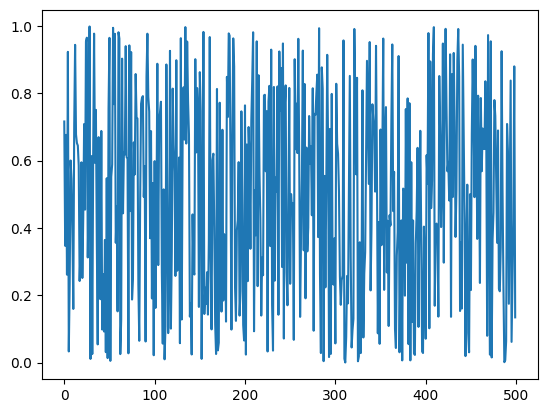

In [106]:
n = 50
p = 10
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25
r= 2
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [8]:
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

def ssp(theta, gamma, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [125]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas

# samples = metroHastings(sigma1 = 1, sigma2 = 0.2, sigmay = 1, sigma_theta = 0.01, X = X, y = y, niter = 50000)
samples = metroHastings(sigma1 = 1, sigma2 = 0.2, sigmay = 1, sigma_theta = 0.01, X = X, y = y, niter = 100000)

Acceptance Rate is 0.00526, with total number of acceptance of 526


tf.Tensor(
[0.1247575  0.10926917 0.10959275 0.08333796 0.15072353 0.07441388
 0.05068629 0.0938137  0.07415427 0.08696307], shape=(10,), dtype=float32)


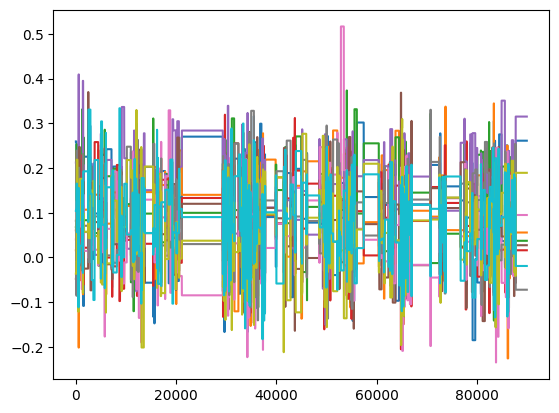

In [128]:
trace = tf.convert_to_tensor(samples[10000:], dtype = tf.float32)
plt.plot(trace)
mean, variance = tf.nn.moments(trace, axes=0)
sample_mean = tf.math.reduce_mean(trace, axis=0)
print(mean)

In [ ]:
sigma1 = 1
sigma2 = 0.1
sigmay = 0.1
gamma = 0.1
rho = 1
sigma_theta = 0.1
p = len(X[1])
n = len(X)
b = p + n
t = 1
niter = 1000

no_accept = 0
theta_0 = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
for i in range(r): theta_0[i] = 1
thetas = theta_0.T[0]

while t < niter:
    t += 1
    #symmetric random walk
    theta_c = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)*sigma_theta), (-1, 1))
    log_joint_candidate = ssp(theta_c, gamma, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
    log_joint_old = ssp(theta_0, gamma, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
    mhr = np.exp(log_joint_candidate - log_joint_old)[0]
    U = np.random.uniform()
    if U <= np.minimum(mhr, 1):
        theta_0 = theta_c
        thetas = np.vstack((thetas, theta_c.T[0]))
        no_accept += 1
        print("%sth acceptance" % str(no_accept))
    else:
        thetas = np.vstack((thetas, theta_0.T[0]))
        # print(thetas)
    # theta_0 = np.vstack(theta0, )

print(no_accept)
print(thetas[-1])